<a href="https://www.kaggle.com/code/alpaypasali/crm-analytics-cltv-prediction?scriptVersionId=282498270" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CUSTOMER LIFETIME VALUE

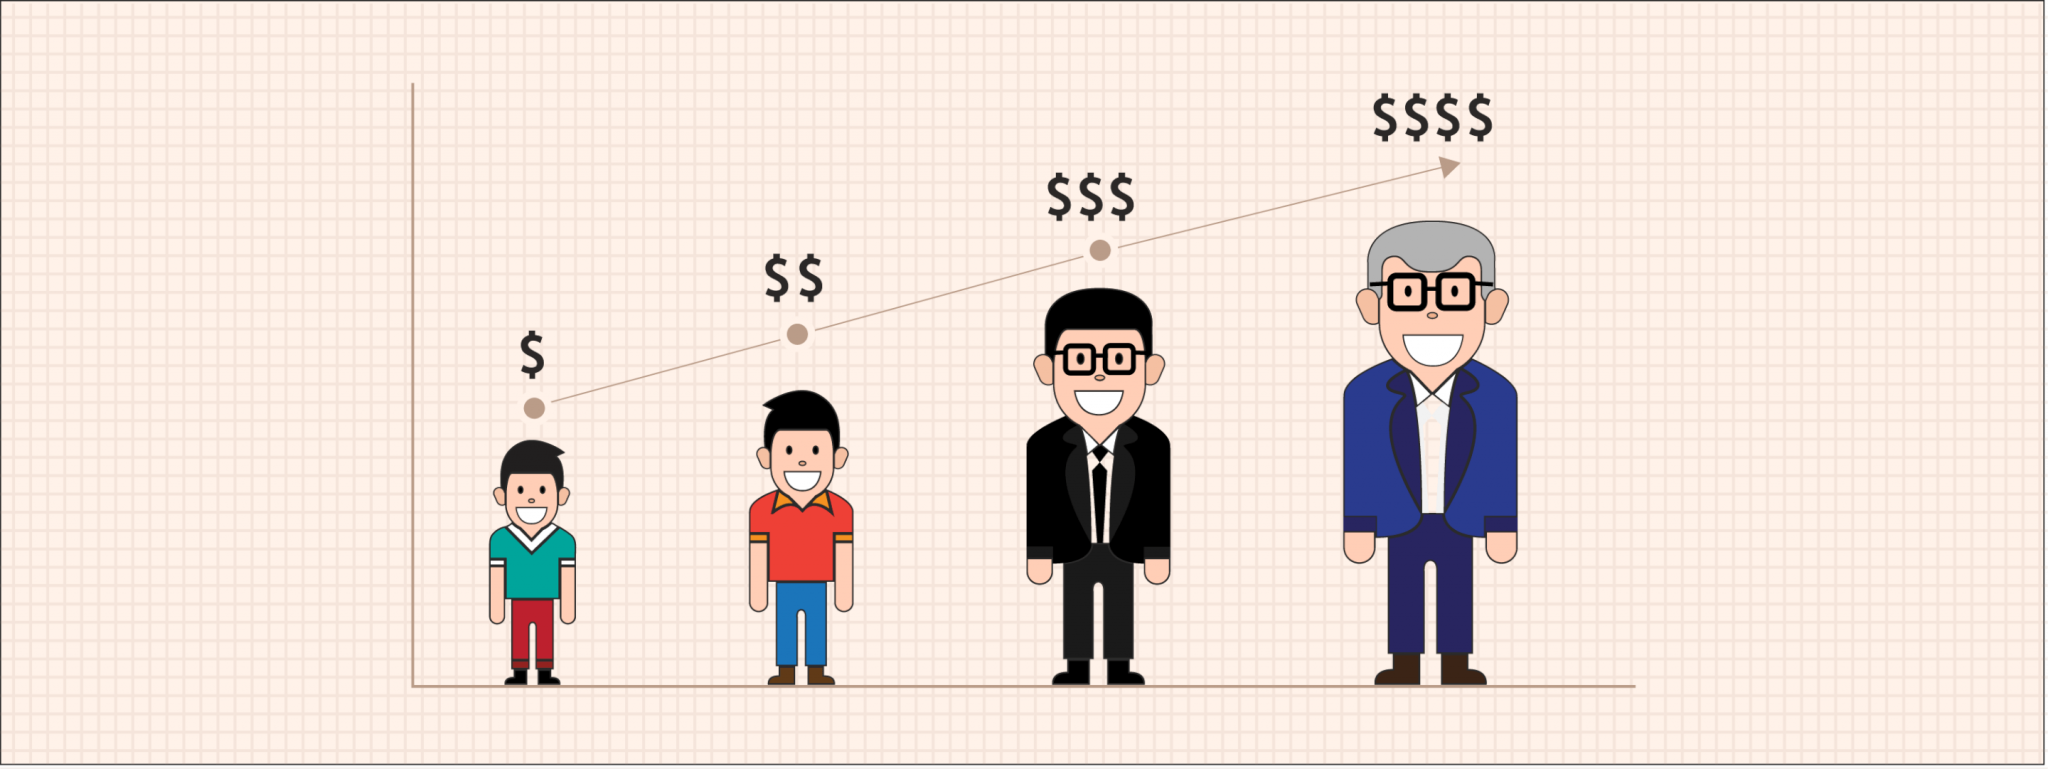

# Customer Lifetime Value (CLTV)

Customer Lifetime Value (CLTV) predicts the **total potential revenue** a customer may generate throughout their relationship with the company.  
By calculating the lifetime value of existing customers, we can compare it with the cost of acquiring new customers and make informed decisions on balancing retention and acquisition.

---

## Why Do We Need It?
1. Understand Customer Value  
2. Optimize Marketing and Sales Budgets  
3. Customer Segmentation and Personalization  
4. Forecast Future Revenue  
5. Guide Business Strategies  

---

## How is it Calculated?

$$
\text{CLTV} = \frac{\text{Customer Value}}{\text{Churn Rate}} \times \text{Profit Margin}
$$

### Customer Value

Customer Value is calculated as:

$$
\text{Customer Value} = \text{Average Order Value} \times \text{Purchase Frequency}
$$

---

## Definitions

- **Churn Rate**: The rate at which customers leave.  
$$
\text{Churn Rate} = 1 - \text{Repeat Rate}
$$

- **Profit Margin**: The profit assumed on customer transactions.  
$$
\text{Profit Margin} = \text{Total Price} \times 0.10
$$

- **Average Order Value (AOV)**: Average revenue per order.  
$$
\text{Average Order Value} = \frac{\text{Total Price}}{\text{Total Transactions}}
$$

- **Purchase Frequency**: How often a customer purchases.  
$$
\text{Purchase Frequency} = \frac{\text{Total Transactions}}{\text{Total Number of Customers}}
$$

- **Repeat Rate**: The proportion of customers who make repeat purchases.  
$$
\text{Repeat Rate} = \frac{\text{Number of Customers with Multiple Purchases}}{\text{Total Number of Customers}}
$$


## CLTV Prediction

CLTV Prediction estimates the **total potential revenue** a customer may generate for a company in the future.

$$
\text{CLTV} = \text{Expected Number of Transactions} \times \text{Expected Average Profit}
$$

Customer purchasing behavior is modeled probabilistically, and predictions are made **conditionally** for each individual customer.

### Advantages of CLTV Prediction
1. Direct marketing budgets toward high-value customers  
2. Identify high churn-risk customers in advance  
3. Enable personalized campaigns and segmentation  
4. Forecast long-term revenue  

---

## Models

### 1️⃣ BG/NBD Model
- **Transaction Process:** Customers make transactions according to a Poisson distribution while active.  
- **Dropout Process:** The probability of a customer becoming inactive follows a Beta distribution.  
- Parameters:  
  - \(x\) = number of transactions  
  - \(t\) = recency (time since last purchase)  
  - \(T\) = customer age (time since first purchase)  
  - \(r, a\) = variation in transaction rate  
  - \(α, β\) = inactivity probability  

### 2️⃣ Gamma-Gamma Submodel
- Predicts the **average profit per transaction** for a customer.  
- Transaction values across customers follow a Gamma distribution.

---

**Summary:**  
- BG/NBD → Predicts the expected number of transactions  
- Gamma-Gamma → Predicts the expected profit per transaction  
- CLTV → Calculated as the product of these two predictions to estimate individual customer lifetime value


In [ ]:
!pip install lifetimes
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [ ]:
sales = pd.read_csv("/kaggle/input/marketing-insights-for-e-commerce-company/Online_Sales.csv")
discounts = pd.read_csv("/kaggle/input/marketing-insights-for-e-commerce-company/Discount_Coupon.csv")
tax = pd.read_excel("/kaggle/input/marketing-insights-for-e-commerce-company/Tax_amount.xlsx")
customers =pd.read_excel("/kaggle/input/marketing-insights-for-e-commerce-company/CustomersData.xlsx")

market=pd.read_csv("/kaggle/input/marketing-insights-for-e-commerce-company/Marketing_Spend.csv")

In [ ]:
df =customers.merge(sales,on='CustomerID')
df.head()

In [ ]:
df =df.merge(tax,on='Product_Category')
df.head()

In [ ]:
df.info()
df.describe().T



In [ ]:
df['Total_Price'] = (df['Quantity'] * df['Avg_Price']) + df['Delivery_Charges'] + (df['Quantity'] * df['Avg_Price'] * df['GST'])
df.head()

In [ ]:

df["coupon_used"] = df["Coupon_Status"].apply(lambda x: 1 if x == "Used" else 0)

df["effective_price"] = df["Total_Price"] * (1 - df["GST"])

coupon_freq = df.groupby("CustomerID")["coupon_used"].sum().reset_index()
coupon_freq.columns = ["CustomerID", "coupon_frequency"]

coupon_freq["segment"] = coupon_freq["coupon_frequency"].apply(
    lambda x: "Loyal (uses coupons often)" if x > 3 else "Occasional"
)

df = df.merge(coupon_freq, on="CustomerID", how="left")


df.head()


In [ ]:
cltv_df = df.groupby("CustomerID").agg({
    "Transaction_ID": "nunique",       # Toplam işlem sayısı
    "effective_price": "sum",          # Toplam harcama (indirim sonrası)
    "Quantity": "sum"      # Satın alma günü sayısı (örnek frekans göstergesi)
})
cltv_df.head()

cltv_df.columns = ['total_transaction', 'total_price', 'total_unit']
cltv_df.head()

In [ ]:
#Average Order Value (average_order_value = total_price / total_transaction)
cltv_df["average_order_value"] = cltv_df["total_price"] / cltv_df["total_transaction"]

In [ ]:
#Purchase Frequency (total_transaction / total_number_of_customers)
cltv_df["purchase_frequency"] = cltv_df["total_transaction"] / cltv_df.shape[0]

cltv_df.head()

In [ ]:
#Repeat Rate & Churn Rate (birden fazla alışveriş yapan müşteri sayısı / tüm müşteriler)
repeat_rate = cltv_df[cltv_df["total_transaction"] > 1].shape[0] / cltv_df.shape[0]
churn_rate = 1 - repeat_rate

In [ ]:
#Profit Margin (profit_margin =  total_price * 0.10)

cltv_df['profit_margin'] = cltv_df['total_price'] * 0.10

In [ ]:
#Customer Value (customer_value = average_order_value * purchase_frequency)
cltv_df['customer_value'] = cltv_df["average_order_value"] * cltv_df["purchase_frequency"]

In [ ]:
#Customer Lifetime Value (CLTV = (customer_value / churn_rate) x profit_margin)
pd.options.display.float_format = "{:.2f}".format
cltv_df["cltv"] = (cltv_df["customer_value"] / churn_rate) * cltv_df["profit_margin"] 
cltv_df.sort_values(by="cltv", ascending=False).head()

In [ ]:
cltv_df["segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

In [ ]:
cltv_df.groupby("segment").agg({"count", "mean", "sum"})

In [ ]:
cltv_df.head()

## CLTV Prediction

In [ ]:
df.head()

In [ ]:
df["Transaction_Date"].max()

today_date = dt.datetime(year=2020, month=1, day=2)
df["Transaction_Date"] = df["Transaction_Date"].apply(pd.to_datetime)
df = df[df["Quantity"] > 0]
df = df[df["effective_price"] > 0]
df.info()

In [ ]:
cltv_p = pd.DataFrame()
cltv_p = df.groupby("CustomerID").agg({
    "Transaction_Date": [lambda x: (x.max() - x.min()).days,
                         lambda x: (today_date - x.min()).days],
    "Transaction_ID": lambda x: x.nunique(),
    "effective_price": lambda x: x.sum()
})

cltv_p.columns = cltv_p.columns.droplevel(0)
cltv_p.columns = ['recency', 'T', 'frequency', 'monetary']
cltv_p.head()


In [ ]:
cltv_p["monetary"] = cltv_p["monetary"] / cltv_p["frequency"]

cltv_p = cltv_p[(cltv_p['frequency'] > 1)]
cltv_p = cltv_p[(cltv_p['recency'] > 1)]
cltv_p["recency"] = cltv_p["recency"] / 7
cltv_p["T"] = cltv_p["T"] / 7
cltv_p.describe().T

In [ ]:
# Creating BG-NBD Model

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_p['frequency'],
        cltv_p['recency'],
        cltv_p['T'])


bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_p['frequency'],
                                                        cltv_p['recency'],
                                                        cltv_p['T']).sort_values(ascending=False).head(10)

cltv_p["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_p['frequency'],
                                               cltv_p['recency'],
                                               cltv_p['T'])


cltv_p["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_p['frequency'],
                                               cltv_p['recency'],
                                               cltv_p['T'])

In [ ]:
#Creating GAMMA-GAMMA Model

ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_p['frequency'], cltv_p['monetary'])

cltv_p["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_p['frequency'],
                                                                             cltv_p['monetary'])

In [ ]:
cltv_f = ggf.customer_lifetime_value(bgf,
                                   cltv_p['frequency'],
                                   cltv_p['recency'],
                                   cltv_p['T'],
                                   cltv_p['monetary'],
                                   time=4 * 3 ,  
                                   freq="W",  
                                   discount_rate=0.01)

cltv_f = cltv_f.reset_index()
cltv_f.head()

cltv_final = cltv_p.merge(cltv_f , on="CustomerID" , how="left")

cltv_final.sort_values(by="clv", ascending=False).head(10)

In [ ]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.sort_values(by="clv", ascending=False).head(50)

cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})
